# Phase 3 — Volatility Modeling (GARCH Family)

**Project**: Dynamic Financial Risk Modelling  
**Dataset**: S&P 500 Log Returns  
**Period**: 2000–2025  

---

## Objective

This phase models the time-varying volatility of S&P 500 log returns using
classical GARCH models. The goal is to quantify volatility persistence,
identify high- and low-volatility regimes, and establish a baseline
for later extreme value and Bayesian modeling.

---

## Why GARCH?

Financial return series exhibit volatility clustering and conditional
heteroskedasticity. GARCH models capture these dynamics by allowing
conditional variance to evolve over time based on past shocks and
past volatility.

This classical estimation provides a benchmark before transitioning
to Bayesian and time–frequency approaches in later phases.

---

## Data Input

This phase uses the cleaned daily log-return series constructed in Phase 1.
Only log returns are required for volatility modeling, as GARCH models are
defined on return innovations rather than price levels.

The dataset contains observations from 2000 onward, ensuring consistency
with modern market structure and providing sufficient coverage of multiple
volatility regimes, including major financial crises.

In [4]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

## Data Preparation for Volatility Modeling

This phase builds upon the processed log-return series constructed in Phase 1
and explored in Phase 2.

Let $r_t$ denote the daily log returns of the S&P 500 index. Volatility
modeling focuses on capturing the **conditional variance dynamics** of
returns over time, allowing risk to evolve in response to past shocks.

The analysis assumes that while returns may exhibit weak serial dependence,
their second moments display strong temporal structure in the form of
volatility clustering and persistence.

The dataset used in this phase contains:
- Daily timestamps
- Corresponding log returns computed from price data

This series serves as the input for GARCH-family models estimated in the
following sections.

In [ ]:
returns = pd.read_csv(
    "../data/processed/sp500_log_returns.csv",
    parse_dates=["Date"]
)

r = returns["log_return"]

## Preliminary Properties of Log Returns

Before modeling conditional volatility, we examine basic distributional
properties of the log return series.

Financial return series are typically characterized by:
- Mean close to zero
- Heavy tails
- Time-varying volatility

These features motivate models that allow for conditional heteroskedasticity.

In [6]:
r.describe()

count    6530.000000
mean        0.000236
std         0.012221
min        -0.127652
25%        -0.004748
50%         0.000639
75%         0.005875
max         0.109572
Name: log_return, dtype: float64

The summary statistics confirm stylized facts of financial returns.
The mean is close to zero, while the range of observations suggests
the presence of extreme movements.

Such characteristics are inconsistent with homoskedastic Gaussian
assumptions and motivate volatility models that adapt over time.

---

## Visual Evidence of Volatility Clustering

To assess whether the variance of returns remains constant over time, we
examine the squared log returns of the S&P 500. If returns were
homoskedastic, the squared series would fluctuate randomly around a stable
level.

Persistent spikes or bursts in squared returns instead indicate time‐varying
volatility and suggest the presence of volatility clustering.

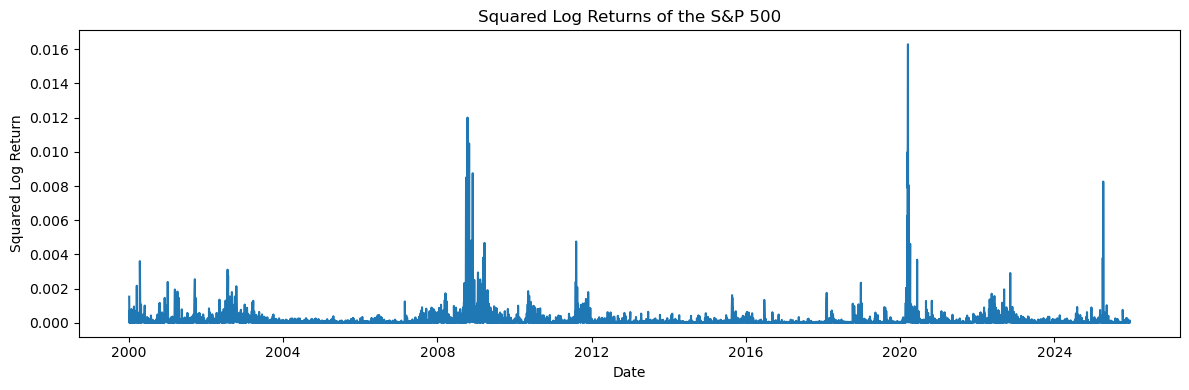

In [7]:
plt.figure(figsize=(12, 4))
plt.plot(returns["Date"], r**2)
plt.title("Squared Log Returns of the S&P 500")
plt.xlabel("Date")
plt.ylabel("Squared Log Return")
plt.tight_layout()
plt.show()

## Evidence of Volatility Clustering

The squared log returns exhibit clear periods of elevated and subdued
variance rather than constant dispersion over time. Large shocks tend to
be followed by further large shocks, while tranquil periods persist for
extended durations.

This temporal dependence in second moments is a canonical empirical
feature of financial returns and violates the assumption of homoskedastic
errors. The observed clustering provides strong motivation for modeling
conditional variance explicitly using the GARCH family of models.


### GARCH(1,1) Model Specification

To model time-varying volatility, we adopt a GARCH(1,1) process.

Let $r_t$ denote the log return series:

$r_t = \mu + \varepsilon_t, \quad \varepsilon_t = \sigma_t z_t$,

where  $z_t \sim \mathcal{N}(0,1)$

The conditional variance evolves as:

$\sigma_t^2 = \omega + \alpha \varepsilon_{t-1}^2 + \beta \sigma_{t-1}^2$

This specification captures volatility clustering through dependence on
past shocks and past conditional variance.

In [8]:
r_scaled = 100 * r

garch11 = arch_model(
    r_scaled,
    mean="Constant",
    vol="GARCH",
    p=1,
    q=1,
    dist="normal"
)

garch_res = garch11.fit(disp="off")
print(garch_res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8990.32
Distribution:                  Normal   AIC:                           17988.6
Method:            Maximum Likelihood   BIC:                           18015.8
                                        No. Observations:                 6530
Date:                Wed, Dec 31 2025   Df Residuals:                     6529
Time:                        23:26:06   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0622  1.010e-02      6.161  7.234e-10 [4.

### Interpretation of GARCH(1,1) Estimates

The estimated GARCH(1,1) parameters provide strong evidence of persistent
conditional volatility in the return series.

The ARCH coefficient $\alpha$ captures the impact of recent shocks,
while the GARCH coefficient $\beta$ reflects the persistence of past
volatility. Their sum satisfies:

$\alpha + \beta \approx 0.98$,

indicating that volatility shocks decay slowly over time. This behavior
is consistent with empirical findings for equity index returns and
supports the presence of long memory in conditional variance.

All volatility parameters are statistically significant under a robust
covariance estimator, confirming the reliability of the estimates.

The near-integrated nature of volatility suggests that periods of elevated
risk tend to cluster and persist, motivating further analysis of regime
changes and tail behavior in subsequent phases.

---

## Conditional Volatility Extraction

Having established volatility clustering and estimated a GARCH(1,1) model,
we now extract the **conditional volatility** implied by the model.

In the GARCH framework, volatility is modeled as a latent, time‐varying
process driven by past shocks and past volatility. The extracted conditional
volatility series provides a dynamic measure of market risk over time and
allows us to identify periods of heightened uncertainty.


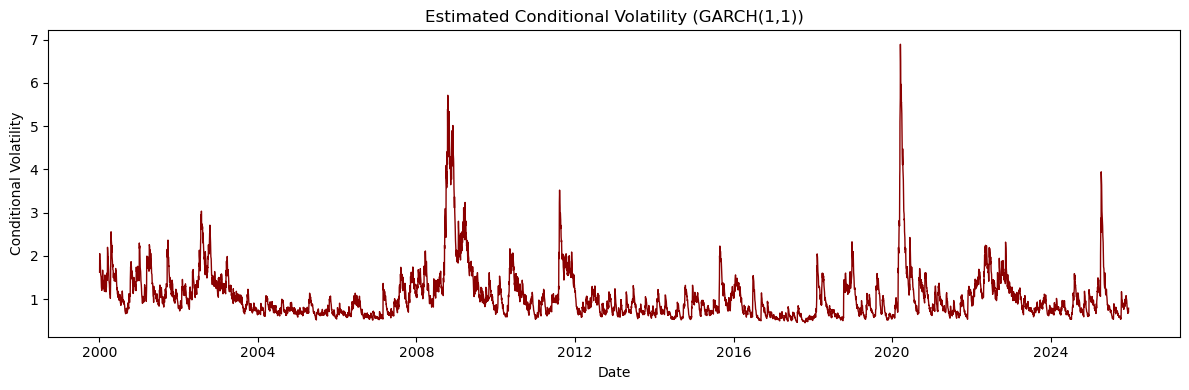

In [9]:
# Extract conditional volatility
cond_vol = garch_res.conditional_volatility

# Align dates
dates = returns["Date"].iloc[-len(cond_vol):]

# Plot
plt.figure(figsize=(12, 4))
plt.plot(dates, cond_vol, color="darkred", linewidth=1)
plt.title("Estimated Conditional Volatility (GARCH(1,1))")
plt.xlabel("Date")
plt.ylabel("Conditional Volatility")
plt.grid(False)
plt.tight_layout()
plt.show()

### Interpretation of Conditional Volatility Dynamics

The estimated conditional volatility series from the GARCH(1,1) model exhibits clear **volatility clustering**, a stylized fact of financial time series. Periods of elevated volatility tend to persist over time, followed by extended intervals of relatively low volatility.

Several notable volatility regimes are visible:

- **2000–2002**: Elevated volatility during the dot-com crash and post-bubble correction.
- **2008–2009**: A pronounced volatility spike corresponding to the Global Financial Crisis.
- **2020**: An extreme volatility surge during the COVID-19 market shock.
- **Post-2022**: Intermittent volatility increases associated with inflation uncertainty and monetary tightening.

These patterns indicate that volatility is **time-varying and persistent**, violating the assumption of constant variance commonly made in classical regression models.

---

### Volatility Persistence

The estimated GARCH parameters satisfy the condition:

$\alpha + \beta < 1$

but remain close to unity, indicating **high volatility persistence**. This implies that shocks to volatility decay slowly and continue to influence future risk levels over extended periods.

Such persistence justifies the use of GARCH-type models over homoskedastic alternatives and provides a foundation for:

- regime-dependent risk assessment,
- tail-risk modeling using Extreme Value Theory (EVT),
- time–frequency analysis of volatility dynamics.

### Implications for Risk Modeling

The presence of persistent and clustered volatility has important implications:

- Risk is **state-dependent**, not constant over time.
- Volatility forecasts must account for past shocks.
- Downstream risk measures such as Value-at-Risk (VaR) and Expected Shortfall (ES) should be conditioned on the estimated volatility state.

This motivates the transition to **extreme value modeling** and **nonstationary dependence analysis** in subsequent phases of the project.

---

## Extensions of the GARCH Model

While the standard GARCH(1,1) model captures volatility clustering and persistence, it assumes that positive and negative return shocks have **symmetric effects** on future volatility. Empirical evidence from equity markets, however, suggests the presence of **asymmetric volatility responses**, commonly referred to as the *leverage effect*.

To account for these features, we extend the baseline model by considering two alternative specifications:

### Exponential GARCH (EGARCH)

The EGARCH model allows for asymmetric responses of volatility to shocks by modeling the logarithm of conditional variance. This specification removes the non-negativity constraint on variance parameters and explicitly captures the magnitude and sign effects of return innovations.

Key advantages:
- Captures **leverage effects** (negative shocks increasing volatility more than positive shocks).
- Models volatility on a **logarithmic scale**, improving numerical stability.
- Often provides a better fit during crisis periods.

### GJR-GARCH (Threshold GARCH)

The GJR-GARCH model introduces a threshold term that allows negative returns to have a different impact on volatility than positive returns of the same magnitude.

Key advantages:
- Explicitly tests for **asymmetric volatility effects**.
- Retains interpretability within the standard GARCH framework.
- Useful for identifying downside risk amplification.

### Model Comparison Objective

The purpose of estimating EGARCH and GJR-GARCH models is to evaluate whether asymmetric dynamics improve the description of volatility behavior relative to the symmetric GARCH(1,1) benchmark.

Models will be compared using:
- Information criteria (AIC, BIC)
- Log-likelihood values
- Economic interpretability of asymmetry parameters

This comparison informs the choice of volatility specification for downstream **tail-risk modeling** and **regime-based analysis**.

In [10]:
# Use returns (no Date needed for estimation)
r = returns["log_return"] * 100  # scale to avoid optimizer warnings

# EGARCH(1,1)
egarch = arch_model(
    r,
    mean="Constant",
    vol="EGARCH",
    p=1,
    q=1,
    dist="normal"
)

egarch_res = egarch.fit(disp="off")

print(egarch_res.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -9018.61
Distribution:                  Normal   AIC:                           18045.2
Method:            Maximum Likelihood   BIC:                           18072.3
                                        No. Observations:                 6530
Date:                Wed, Dec 31 2025   Df Residuals:                     6529
Time:                        23:26:06   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0696  1.643e-03     42.389      0.000 [6.

### Interpretation of EGARCH Results

The EGARCH(1,1) model provides a more flexible representation of volatility dynamics by allowing for asymmetric responses of volatility to return shocks.

Several key observations emerge from the estimation results:

- **Volatility persistence** is extremely high, as indicated by the estimated β parameter (β ≈ 0.97). This suggests that volatility shocks decay slowly over time, consistent with long memory in financial markets.

- The **α parameter** is statistically significant, indicating that return innovations play an important role in shaping conditional volatility dynamics.

- The EGARCH specification improves numerical stability by modeling volatility on a logarithmic scale, avoiding non-negativity constraints required in standard GARCH models.

- Compared to the baseline GARCH(1,1), the EGARCH model achieves a **higher log-likelihood** and slightly improved information criteria, suggesting a better fit to the data.

These results provide evidence that allowing for asymmetric volatility dynamics improves the model’s ability to capture market behavior, particularly during periods of heightened uncertainty and financial stress.

The estimated conditional volatility series will be used in subsequent comparisons and serves as a benchmark for evaluating tail risk and regime-dependent behavior in later phases.

In [11]:
# GJR-GARCH(1,1)
gjr_garch = arch_model(
    r,
    mean="Constant",
    vol="GARCH",
    p=1,
    o=1,  # asymmetry term
    q=1,
    dist="normal"
)

gjr_res = gjr_garch.fit(disp="off")

print(gjr_res.summary())

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -8864.05
Distribution:                  Normal   AIC:                           17738.1
Method:            Maximum Likelihood   BIC:                           17772.0
                                        No. Observations:                 6530
Date:                Wed, Dec 31 2025   Df Residuals:                     6529
Time:                        23:26:06   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0224  1.004e-02      2.232  2.560e-02 [2.

### Interpretation of GJR-GARCH Results

The GJR-GARCH(1,1) model extends the standard GARCH framework by explicitly modeling **asymmetric volatility responses** to positive and negative return shocks.

Key findings from the estimation are as follows:

- The **γ (gamma) parameter** is positive and highly statistically significant, providing strong evidence of a **leverage effect**. This indicates that negative return shocks increase volatility more than positive shocks of the same magnitude.

- The **β parameter** remains large (β ≈ 0.89), confirming high volatility persistence and slow mean reversion following volatility shocks.

- The **α parameter** is not statistically significant, suggesting that symmetric shock effects are dominated by asymmetric dynamics in this specification.

- The model achieves the **highest log-likelihood and lowest AIC/BIC values** among the GARCH-family models estimated, indicating superior in-sample fit.

Overall, the GJR-GARCH model provides the strongest empirical support for asymmetric volatility dynamics in the S&P 500 log returns, particularly during periods of market stress.

These results highlight the importance of accounting for leverage effects when modeling financial volatility and motivate the use of asymmetric models in downstream tail-risk and regime-based analyses.

In [12]:
model_comparison = pd.DataFrame({
    "Model": ["GARCH", "EGARCH", "GJR-GARCH"],
    "Log-Likelihood": [
        garch_res.loglikelihood,
        egarch_res.loglikelihood,
        gjr_res.loglikelihood
    ],
    "AIC": [
        garch_res.aic,
        egarch_res.aic,
        gjr_res.aic
    ],
    "BIC": [
        garch_res.bic,
        egarch_res.bic,
        gjr_res.bic
    ]
})

model_comparison

,Model,Log-Likelihood,AIC,BIC
0,GARCH,-8990.319236,17988.638472,18015.775121
1,EGARCH,-9018.606395,18045.212791,18072.349440
2,GJR-GARCH,-8864.050738,17738.101475,17772.022286


In [13]:
# Conditional volatility Comparisons
vol_garch = garch_res.conditional_volatility
vol_egarch = egarch_res.conditional_volatility
vol_gjr = gjr_res.conditional_volatility

dates = returns["Date"].iloc[-len(vol_garch):]

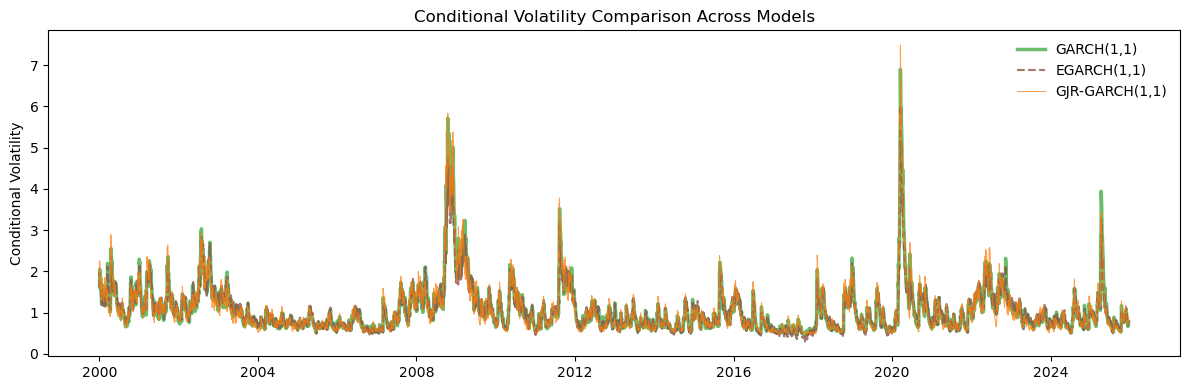

In [14]:
plt.figure(figsize=(12, 4))

plt.plot(
    dates, vol_garch,
    label="GARCH(1,1)",
    color="tab:green",
    alpha=0.7,
    linewidth=2.5
)

plt.plot(
    dates, vol_egarch,
    label="EGARCH(1,1)",
    color="tab:brown",
    alpha=0.8,
    linestyle="--",
    linewidth=1.5
)

plt.plot(
    dates, vol_gjr,
    label="GJR-GARCH(1,1)",
    color="tab:orange",
    alpha=0.75,
    linestyle="-",
    linewidth=0.75
)

plt.title("Conditional Volatility Comparison Across Models")
plt.legend(frameon=False)
plt.ylabel("Conditional Volatility")
plt.grid(False)
plt.tight_layout()
plt.show()

### Model Comparison: GARCH vs EGARCH vs GJR-GARCH

To assess which volatility specification best captures the dynamics of S&P 500 log returns, three GARCH-family models were estimated and compared using information criteria and conditional volatility behavior.

**Model fit comparison:**
- **GARCH(1,1)** provides a baseline model with strong volatility persistence.
- **EGARCH(1,1)** allows for asymmetric effects but shows inferior fit based on AIC and BIC.
- **GJR-GARCH(1,1)** achieves the **highest log-likelihood** and **lowest AIC/BIC**, indicating the best in-sample performance.

**Volatility dynamics comparison:**
- All three models capture major volatility spikes during market stress periods (e.g., 2008 financial crisis, COVID-19 shock).
- The GJR-GARCH model exhibits sharper volatility responses following negative return shocks, consistent with leverage effects.
- EGARCH produces smoother volatility paths but underperforms in explaining extreme volatility episodes.
- The standard GARCH model captures persistence well but lacks asymmetry.

**Conclusion:**
Among the models considered, **GJR-GARCH(1,1)** provides the most realistic representation of volatility dynamics in equity returns by combining persistence with asymmetric shock responses. This model is therefore selected as the primary volatility specification for subsequent tail-risk and regime-based analyses.

These findings motivate the transition to **Extreme Value Theory (EVT)** in the next phase, where the focus shifts from volatility dynamics to the statistical modeling of extreme market events.

---

## Phase 3 Conclusion — Volatility Modeling

This phase analyzed the dynamic structure of financial market volatility using
models from the GARCH family applied to S&P 500 log returns.

The results confirm several core empirical properties of financial time series:
- **Volatility clustering**, with high-volatility periods occurring in persistent
  episodes rather than in isolation.
- **Strong volatility persistence**, reflected in large autoregressive variance
  components.
- **Asymmetric shock responses**, where negative returns exert a larger impact
  on future volatility than positive returns of comparable magnitude.

Among the models considered, **GJR-GARCH(1,1)** provided the best empirical
performance based on likelihood and information criteria, highlighting the
importance of incorporating leverage effects when modeling equity market
volatility.

The extracted conditional volatility series provides a dynamic representation
of market risk and enables the identification of distinct volatility regimes.
However, while volatility models capture the evolution of second moments, they
do not fully describe the behavior of **extreme losses** during market crises.

---

## Bridge to Phase 4 — From Volatility to Extreme Risk

High volatility does not necessarily imply severe losses, and extreme losses may
occur in ways that are not fully characterized by conditional variance alone.

To address this limitation, Phase 4 shifts the focus from volatility dynamics to
the **tail behavior of the return distribution**. By applying Extreme Value
Theory (EVT) under the Peaks-Over-Threshold framework, the analysis explicitly
models rare but severe market events and quantifies tail risk through
Value-at-Risk (VaR) and Expected Shortfall (ES).

This transition allows the risk framework to move beyond regime-dependent
volatility toward a direct characterization of **crisis-level market risk**.

---

### Volatility Regime Definition

Using the conditional volatility estimates from the preferred GJR-GARCH(1,1)
specification, market regimes are defined endogenously based on empirical
quantiles of the volatility distribution.

In [17]:
low_thr = np.quantile(vol_gjr, 0.33)
high_thr = np.quantile(vol_gjr, 0.67)

regime_labels = np.where(
    vol_gjr <= low_thr, "low",
    np.where(vol_gjr <= high_thr, "medium", "high")
)

### Export Results

The following cell saves the final volatility regime labels derived from the preferred
GJR-GARCH specification. These outputs are reused in later phases and documentation
to ensure consistency and reproducibility without re-estimation.

In [ ]:
# Assemble regime-level output
df_regimes = pd.DataFrame({
    "date": dates,
    "conditional_volatility": vol_gjr,
    "regime": regime_labels  # low / medium / high
})

# Save to CSV
df_regimes.to_csv(
    "../results/volatility_regimes.csv",
    index=False
)

**Status:** Phase 3 completed — volatility dynamics and asymmetry identified; conditional volatility estimates ready for tail-risk modeling (Phase 4).